

# 두 자산간 가격 차이를 이용한 헷징 매매 전략 지도학습
두 자산간 가격 차이를 나타낸 시계열 데이터에서 이상적인 동작 (buy=0, sell=1) 을 학습하고, 이를 예측하는 지도학습 모델.

<a id='1.1'></a>
## 1.1. 패키지 로드

In [1]:
# 라이브러리 로드
import heapq
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

<a id='1.2'></a>
## 1.2. 데이터 가져오기

In [2]:
working_dir = 'data/'

# price_funding.csv에서 dataset 저장
rawdataset = pd.read_csv(working_dir+'price_funding.csv')

#경고 무시
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 2. 탐색적 데이터 분석

<a id='2.1'></a>
## 2.1. 기술 통계

In [3]:
# 데이터셋 구조 확인
rawdataset.shape

# 데이터 확인
pd.set_option('display.width', 100)
rawdataset.tail(5)

,timestamp,spot_close,futures_close,price_diff,Funding Rate
8755,2025-02-16 02:00:00,97525.91,97480.4,45.51,0.000000
8756,2025-02-16 01:00:00,97640.98,97603.0,37.98,0.000000
8757,2025-02-16 00:00:00,97590.01,97546.0,44.01,0.000017
8758,2025-02-15 23:00:00,97578.44,97533.9,44.54,0.000000
8759,2025-02-15 22:00:00,97555.75,97504.9,50.85,0.000000


<a id='3'></a>
# 3. 데이터 준비

<a id='3.1'></a>
## 3.1. 데이터 청소

In [4]:
# null 값 확인
print('Null Values =',rawdataset.isnull().values.any())

Null Values = False


nan값 있으면 dropna로 삭제하든 ffill로 보간하든 해야한다. 안하면 나중에 오류남

In [5]:
# null 값 보간
rawdataset[rawdataset.columns.values] = rawdataset[rawdataset.columns.values].ffill()

In [6]:
rawdataset.tail()

,timestamp,spot_close,futures_close,price_diff,Funding Rate
8755,2025-02-16 02:00:00,97525.91,97480.4,45.51,0.000000
8756,2025-02-16 01:00:00,97640.98,97603.0,37.98,0.000000
8757,2025-02-16 00:00:00,97590.01,97546.0,44.01,0.000017
8758,2025-02-15 23:00:00,97578.44,97533.9,44.54,0.000000
8759,2025-02-15 22:00:00,97555.75,97504.9,50.85,0.000000


<a id='3.3'></a>
## 3.2. 특성 엔지니어링




예측을 만들기 위한 특성들을 정의한다.

아직 이건 연구가 더 필요하다. 모델 성능에 가장 중요한 영향을 주는데, 가장 부족한 부분이다.

In [7]:
df=rawdataset["price_diff"]

MAX_POSITIONS = 4000

min_heap = []
best_trades = []

for sell_index in tqdm(range(len(df)), desc="🔄 매도 시점 처리 중", unit="step"):
    sell_price = df.iloc[sell_index]

    # 현재 매도 시점까지의 모든 매수 가능 시점을 힙에 저장
    heapq.heappush(min_heap, (df.iloc[sell_index], sell_index))

    # 최소 힙에서 가장 낮은 매수 가격을 가져옴 (즉, 가장 수익이 큰 조합)
    while min_heap and min_heap[0][1] < sell_index:
        buy_price, buy_index = heapq.heappop(min_heap)
        profit = sell_price - buy_price

        if profit > 0:
            best_trades.append((buy_index, sell_index, profit))

best_trades = sorted(
    tqdm(best_trades, desc="📊 정렬 진행 중", unit="trade"),
    key=lambda x: x[2],
    reverse=True
)[:MAX_POSITIONS]

trade_actions = [0] * len(df)

for buy_idx, sell_idx, _ in best_trades:
    trade_actions[buy_idx] = 1
    trade_actions[sell_idx] = 0

# trade_actions

📊 정렬 진행 중: 100%|█████████████████████████████████████████████████████| 8747/8747 [00:00<00:00, 5834538.34trade/s]


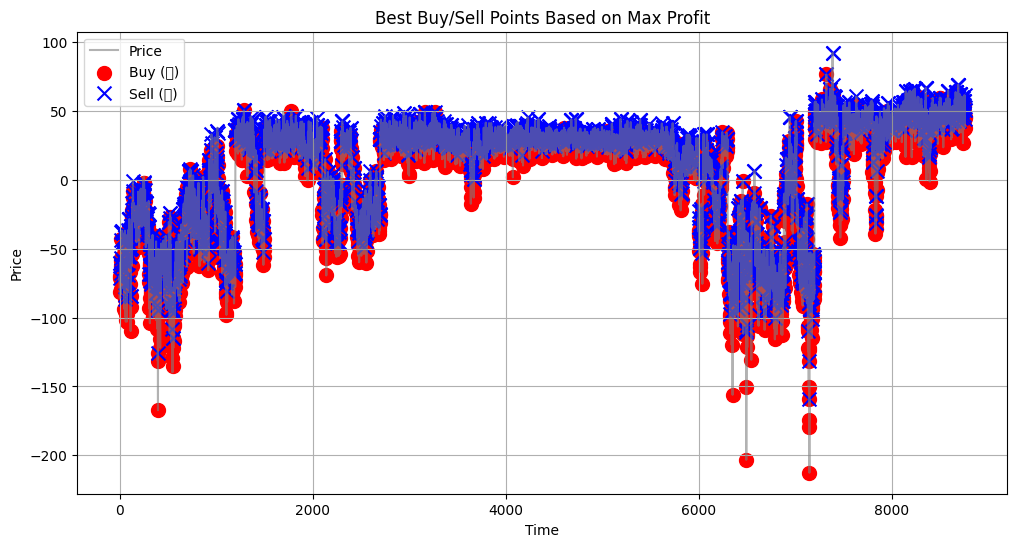

In [8]:
# 그래프 생성 및 매수 매도 시점 표시
plt.figure(figsize=(12, 6))
plt.plot(df.values, label="Price", color="gray", alpha=0.6)

buy_indices = [t[0] for t in best_trades]
sell_indices = [t[1] for t in best_trades]
buy_prices = [df.iloc[i] for i in buy_indices]
sell_prices = [df.iloc[i] for i in sell_indices]

plt.scatter(buy_indices, buy_prices, color='red', label="Buy (🔴)", marker="o", s=100)
plt.scatter(sell_indices, sell_prices, color='blue', label="Sell (🔵)", marker="x", s=100)

plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.title("Best Buy/Sell Points Based on Max Profit")
plt.grid()

plt.show()

In [9]:
# 기존 df에 병합 및 dataset 최신화
dataset = pd.DataFrame({'Price': df, 'action': trade_actions})

In [10]:
# EMA 계산
def EMA(df, n):
    EMA = pd.Series(df['Price'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA1'] = EMA(dataset, 1)
dataset['EMA3'] = EMA(dataset, 3)
dataset['EMA10'] = EMA(dataset, 10)
dataset.head()

# 모멘텀 (MOM) 계산
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
dataset['MOM1'] = MOM(dataset['Price'], 1)
dataset['MOM3'] = MOM(dataset['Price'], 3)

#상대강도지수 (RSI) 계산
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI1'] = RSI(dataset['Price'], 1)
dataset['RSI3'] = RSI(dataset['Price'], 3)
dataset['RSI10'] = RSI(dataset['Price'], 10)

# 이동평균 (MA) 계산
def MA(df, n):
    MA = pd.Series(df['Price'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA1'] = MA(dataset, 1)
dataset['MA3'] = MA(dataset, 3)
dataset['MA10'] = MA(dataset, 10)

In [11]:
dataset.tail()

,Price,action,EMA1,EMA3,EMA10,MOM1,MOM3,RSI1,RSI3,RSI10,MA1,MA3,MA10
8755,45.51,1,45.51,51.109632,51.060373,-16.02,-0.01,0.0,35.152451,47.084182,45.51,53.870000,51.000
8756,37.98,1,37.98,44.544816,48.682123,-7.53,-16.59,0.0,25.744941,42.921520,37.98,48.340000,49.878
8757,44.01,0,44.01,44.277408,47.832646,6.03,-17.52,100.0,43.808499,47.084096,44.01,42.500000,49.518
8758,44.54,1,44.54,44.408704,47.233983,0.53,-0.97,100.0,45.554674,47.458301,44.54,42.176667,49.684
8759,50.85,0,50.85,47.629352,47.891441,6.31,12.87,100.0,64.986031,51.953003,50.85,46.466667,49.032


In [12]:
dataset = dataset.dropna(axis=0)

In [13]:
dataset.tail()

,Price,action,EMA1,EMA3,EMA10,MOM1,MOM3,RSI1,RSI3,RSI10,MA1,MA3,MA10
8755,45.51,1,45.51,51.109632,51.060373,-16.02,-0.01,0.0,35.152451,47.084182,45.51,53.870000,51.000
8756,37.98,1,37.98,44.544816,48.682123,-7.53,-16.59,0.0,25.744941,42.921520,37.98,48.340000,49.878
8757,44.01,0,44.01,44.277408,47.832646,6.03,-17.52,100.0,43.808499,47.084096,44.01,42.500000,49.518
8758,44.54,1,44.54,44.408704,47.233983,0.53,-0.97,100.0,45.554674,47.458301,44.54,42.176667,49.684
8759,50.85,0,50.85,47.629352,47.891441,6.31,12.87,100.0,64.986031,51.953003,50.85,46.466667,49.032


<a id='3.4'></a>
## 3.3. 데이터 시각화

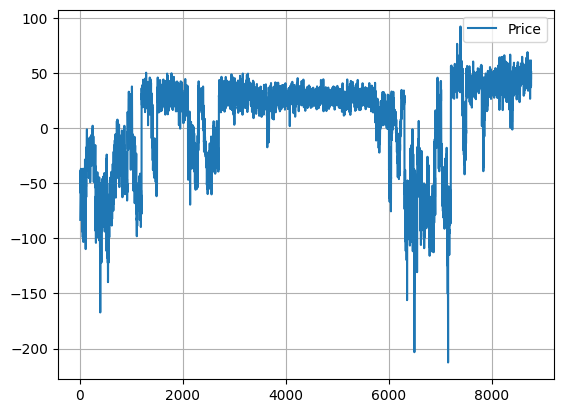

In [14]:
# 트렌드
dataset[['Price']].plot(grid=True)
plt.show()

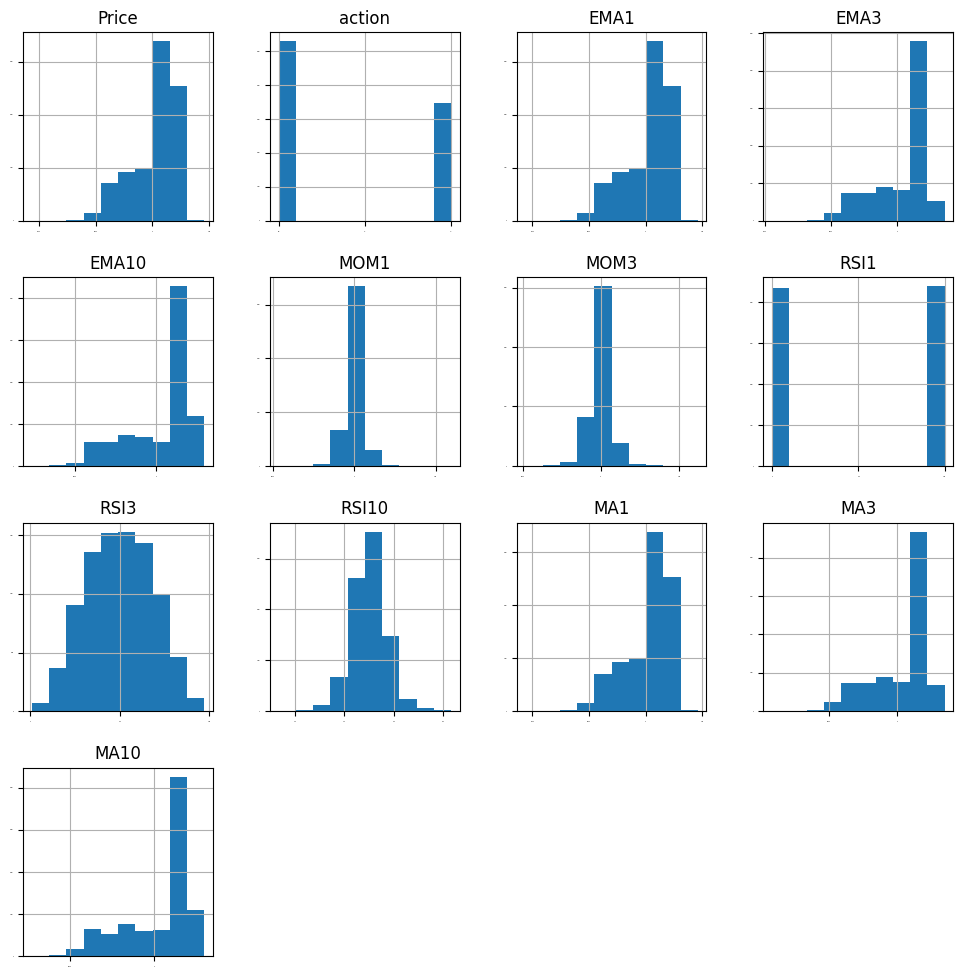

In [15]:
# 히스토그램
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

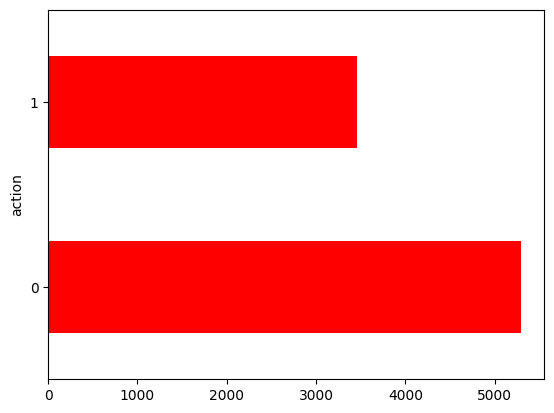

In [16]:
# 행동들 간 비율
fig = plt.figure()
plot = dataset.groupby(['action']).size().plot(kind='barh', color='red')
plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

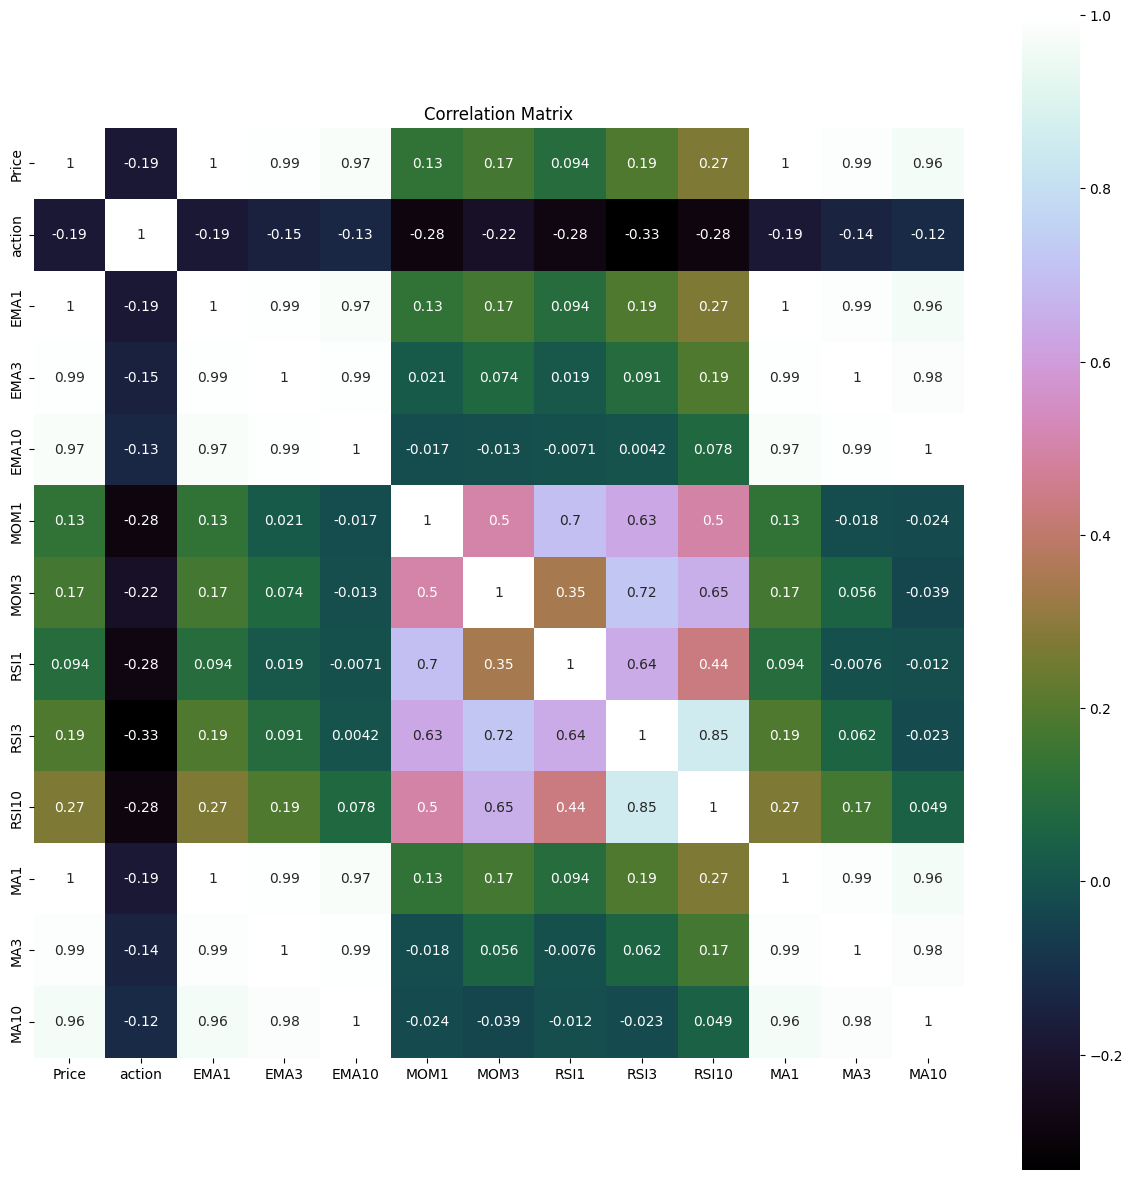

In [17]:
# 상관계수
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<a id='4'></a>
# 4. 알고리즘 및 모델 평가

<a id='4.1'></a>
## 4.1. train test 분리

80퍼는 학습셋으로, 20퍼는 평가셋으로

In [18]:
# split out validation dataset for the end
subset_dataset= dataset
Y= subset_dataset["action"]
X = subset_dataset.loc[:, dataset.columns != 'action']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

<a id='4.2'></a>
## 4.2. 테스트 옵션 및 평가 지표


In [19]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

<a id='4.3'></a>
## 4.3. 모델 및 알고리즘 비교

<a id='4.3.1'></a>
### 4.3.1. 모델 정의

In [20]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

### 4.3.2. K-겹 교차 검증

In [21]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.676056 (0.012092)
LDA: 0.677058 (0.016840)
KNN: 0.651908 (0.021218)
CART: 0.613894 (0.016946)
NB: 0.652905 (0.018287)
NN: 0.660337 (0.028353)
AB: 0.692632 (0.014745)
GBM: 0.690488 (0.016095)
RF: 0.679916 (0.022920)


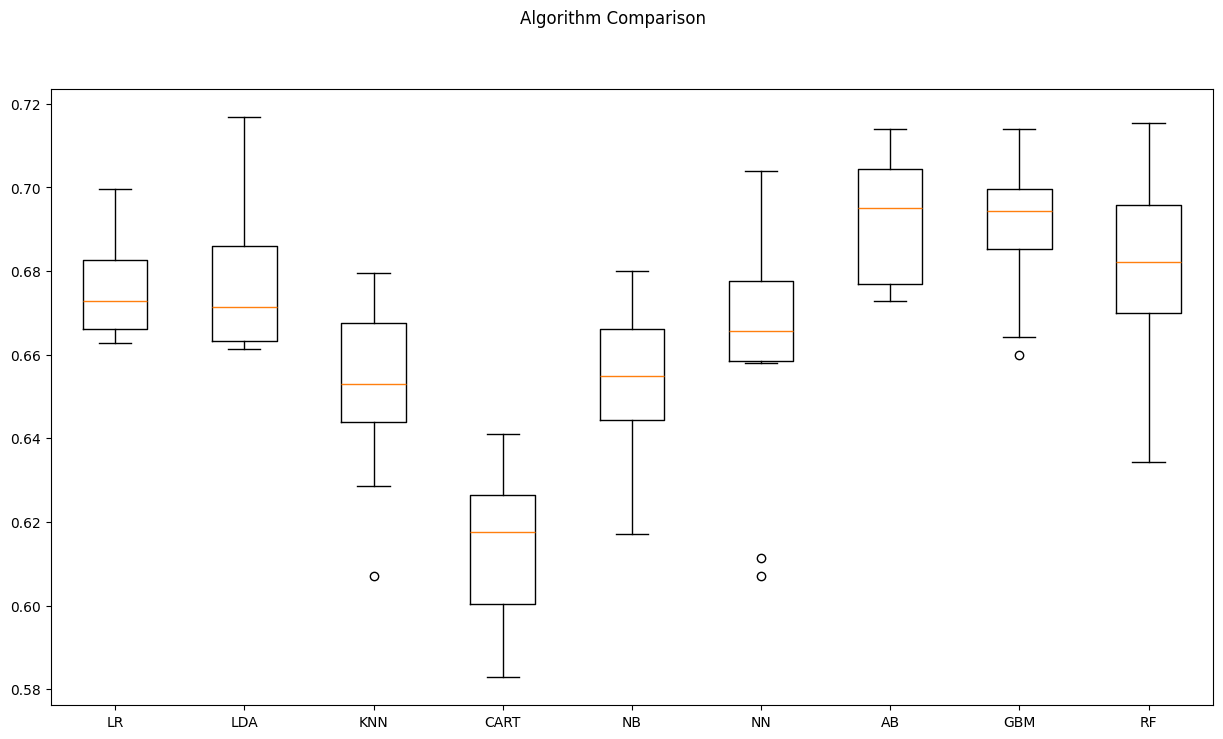

In [22]:
# 알고리즘 비교
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

<a id='5'></a>
# 5. 그리드 서치를 통한 모델 튜닝

랜덤 포레스트의 하이퍼파라미터를 그리드 서치 선택하여 튜닝한다.

In [23]:
# 랜덤 포레스트 그리드 서치
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# 결과 출력
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.694920 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#6 0.691207 (0.020835) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.691349 (0.020834) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#8 0.685205 (0.020707) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#3 0.692916 (0.013583) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.689347 (0.018198) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#4 0.691778 (0.019956) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#2 0.693349 (0.019231) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.694920 (0.017602) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


<a id='6'></a>
# 6. 최적 모델 정의

<a id='6.1'></a>
## 6.1. 테스트셋에서의 성능 평가

In [24]:
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression()
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [25]:
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.6971428571428572
[[849 227]
 [303 371]]
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      1076
           1       0.62      0.55      0.58       674

    accuracy                           0.70      1750
   macro avg       0.68      0.67      0.67      1750
weighted avg       0.69      0.70      0.69      1750



<Axes: xlabel='Predicted', ylabel='Actual'>

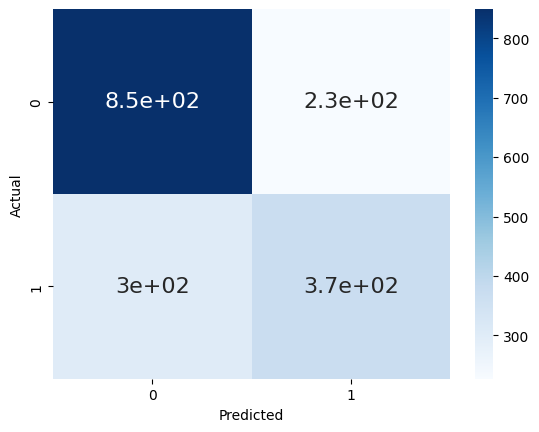

In [26]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

<a id='6.2'></a>
## 6.2. 변수 및 특성 중요도
모델에서 가장 중요한 특성 및 변수를 알아보자

Text(0.5, 0, 'Variable Importance')

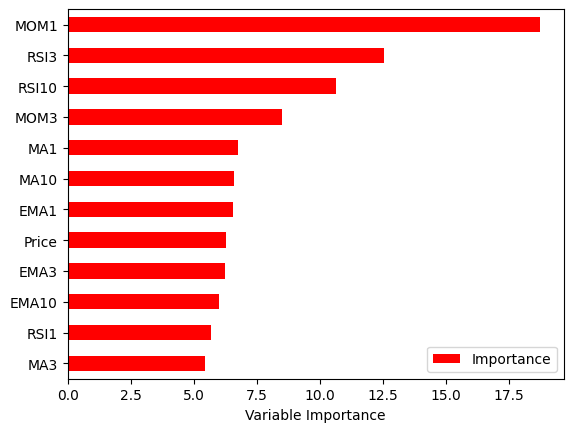

In [27]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

<a id='7'></a>
## 7. 결과 백테스트

<Axes: >

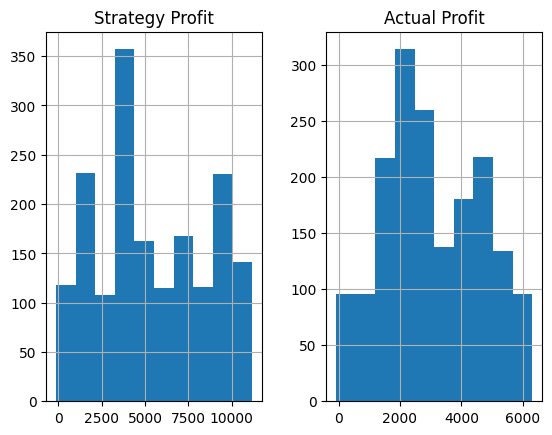

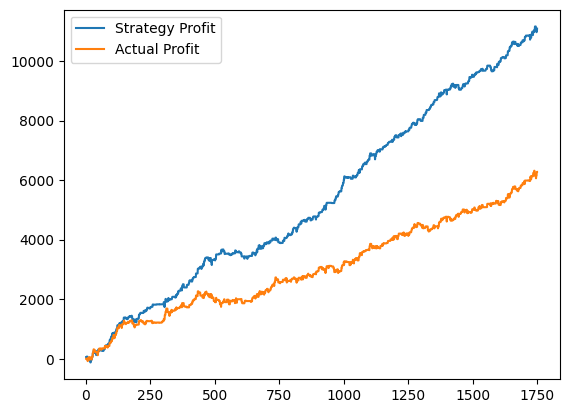

In [29]:
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['action_pred'] = predictions
backtestdata['action_actual'] = Y_validation
# backtestdata['Market Returns'] = X_validation['Price'].pct_change()
# backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['action_actual'].shift(1)
# backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['action_pred'].shift(1)
backtestdata['Market Profit'] = X_validation['Price'].diff()
backtestdata['Strategy Profit'] = backtestdata['Market Profit'] * (backtestdata['action_pred'].shift(1) == 1)
backtestdata['Actual Profit'] = backtestdata['Market Profit'] * (backtestdata['action_actual'].shift(1) == 1)

backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Profit','Actual Profit']].cumsum().hist()
backtestdata[['Strategy Profit','Actual Profit']].cumsum().plot()